In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
from sys import platform
import f90nml
from importlib import reload
import sys
sys.path.append('../ice4')
import retrievestuff as rs
import weibull
import scipy.stats as stats

In [8]:
%matplotlib notebook

In [9]:
# Have to do this in case of different operating systems
if platform == "linux" or platform == "darwin":
    slash = '/'
else: # This is assumed to be Windows
    slash = '\\'
#print(slash)

In [51]:
foldername = "Case2.0 (calibration)"; filename = "surface_filtered.txt"

# Load a height file (for synthetic data)
#filename = "surface.txt"

sollast = np.loadtxt(foldername+slash+filename)
Ny, Nx = np.shape(sollast); #print(sollast.shape)
Ntot = np.size(sollast)
print("Nx =", Nx)
print("Ny =", Ny)
print('Npts = ', Ntot)

# Get other parameters
params = f90nml.read(foldername+slash+'parameters.nml')
Lx = params['parameters']['Lx']; print("Lx =", Lx)
Ly = params['parameters']['Ly']; print("Ly =", Ly)

Nx = 41
Ny = 43
Npts =  1763
Lx = 22.808908000000002
Ly = 23.949353400000003


In [52]:
x = np.linspace(0,Lx,Nx); #print(x[1]-x[0])
y = np.linspace(0,Ly,Ny); 
xgrid,ygrid = np.meshgrid(x,y); #print(xgrid.shape)
dx = x[1]-x[0]
dy = y[1]-y[0]
dzdx = np.diff(sollast, axis=0)/dx
dzdy = np.diff(sollast, axis = 1)/dy #we are not sure which axis is which
Z2 = dzdx[:, 1:]**2+dzdy[1:, :]**2
print(np.shape(Z2))
Z2flat = np.reshape(Z2, (Nx-1)*(Ny-1))
print(np.shape(Z2flat))

(42, 40)
(1680,)


In [53]:
def Weibull(Z2,sigma2W,etaW):
    # Getting the Weibull distribution
    rhoW = etaW/(sigma2W)*(Z2/sigma2W)**(etaW-1)*np.exp(-(Z2/sigma2W)**etaW)
    return rhoW

In [54]:
nbins_max = 14
nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says nbins = ', nbins_sturges)
nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
Z2max = .06
Z2bins = np.linspace(0,Z2max,nbins-1)
#counts, bins, meanZ2, error = rs.getrhoofz2(sollast,dx,dy,Z2bins=Z2bins, levels=3)
counts, bins, meanZ2= rs.getrhoofz2(sollast,dx,dy,Z2bins=Z2bins)

my_bins = Z2bins[0:-1]

std = np.std(Z2)
mean = np.mean(Z2)
print(mean)
print(std)

integral_rho = np.trapz(counts, my_bins)

print(integral_rho)
counts = counts/integral_rho

Sturges rule says nbins =  11
Using nbins =  11
0.00589247410643
0.00584973142828
7.43333333333


<IPython.core.display.Javascript object>


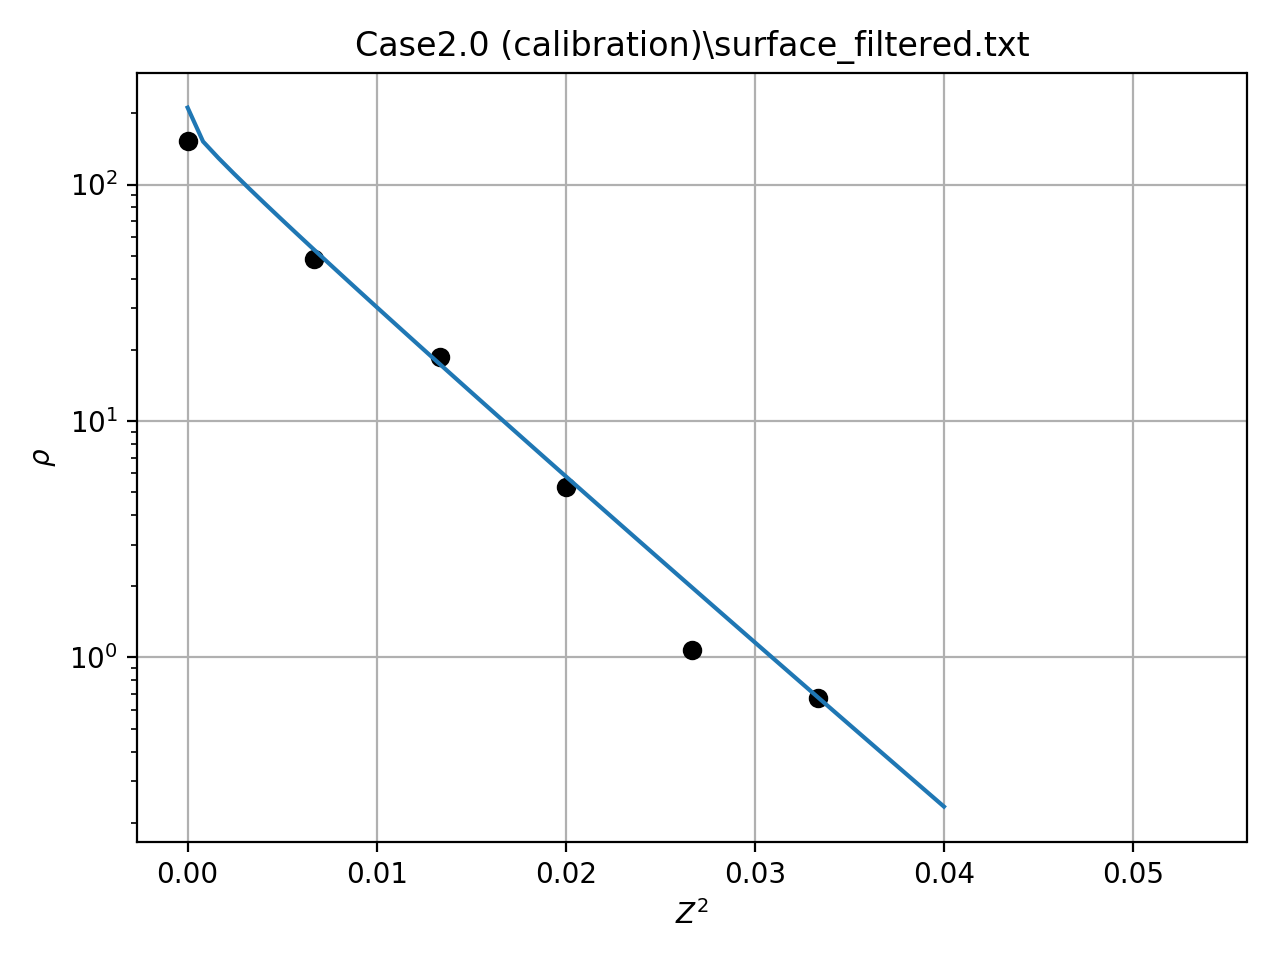

0.0763085840519


In [59]:
fig = plt.figure()
plt.semilogy(my_bins, counts, 'ok', label='Numerical result')
plt.grid(True)
plt.xlabel('$Z^2$')
plt.ylabel(r'$\rho$')
plt.title(foldername+slash+filename)


sigma2W = 0.005823
print(np.sqrt(sigma2W))
etaW = 0.9728
Z2max = .04
Z2 = np.linspace(0.000001,Z2max,50)
myWeibull = Weibull(Z2,sigma2W,etaW)
plt.semilogy(Z2, myWeibull)
plt.grid(True)

<IPython.core.display.Javascript object>


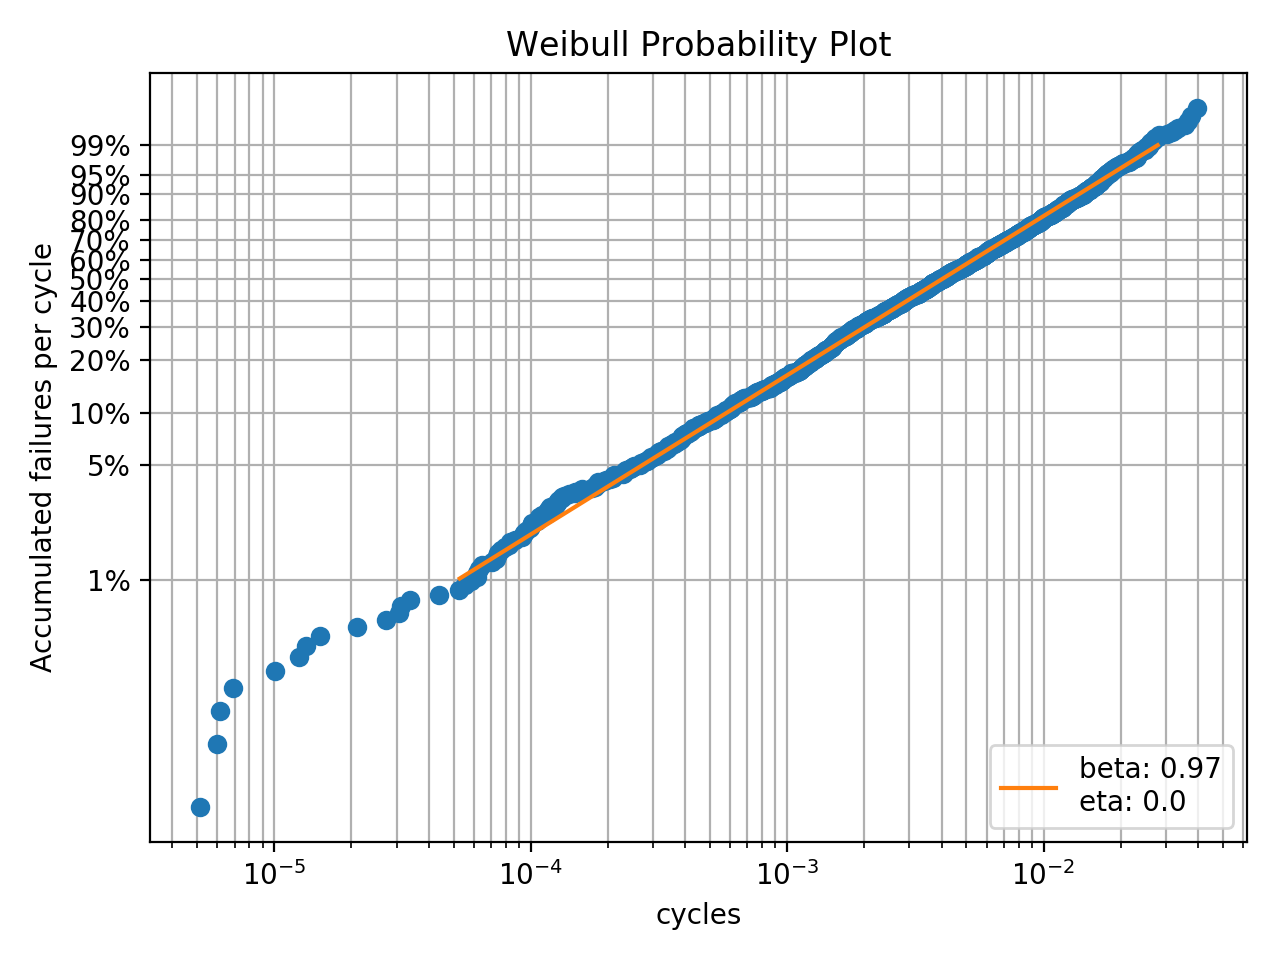

fit method          maximum likelihood estimation
confidence                                    0.9
beta lower limit                         0.942511
beta nominal                             0.972814
beta upper limit                          1.00409
eta lower limit                        0.00557564
eta nominal                            0.00582302
eta upper limit                        0.00608139
mean life                              0.00589371
median life                            0.00399508
b10 life                              0.000576122
dtype: object


In [56]:
#does weibull analysis on experimental data
analysis = weibull.Analysis(Z2flat)
analysis.fit(method='mle')
plt.figure()
analysis.probplot()
print(analysis.stats)